In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [3]:
import pandas as pd
import numpy as np         
from random import shuffle
from PIL import Image #pillow
import matplotlib.pyplot as plt
import seaborn as sns
# supressing warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import MobileNet
train1 = np.load("/content/gdrive/My Drive/train_data.npy",allow_pickle=True)
X, y = zip(*train1)
#list to array
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
X_train.shape

(225, 600, 600, 3)

In [5]:
# parameters for architecture
input_shape = (600, 600, 3)
num_classes = 2
conv_size = 32

# parameters for training
batch_size = 8
num_epochs = 2

# load MobileNet from Keras
MobileNet_model = MobileNet(include_top=False, input_shape=input_shape)

# add custom Layers
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
MobileNet_model = Model(inputs = MobileNet_model.input, outputs = Custom_Output)
# compile the model
MobileNet_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

MobileNet_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600, 600, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 601, 601, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 300, 300, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 300, 300, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 300, 300, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 300, 300, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 300, 300, 32)      128 

In [6]:
history = MobileNet_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=13,
                    verbose=1,
                    validation_split=0.1)

Train on 202 samples, validate on 23 samples
Epoch 1/13
202/202 [==============================] - 283s 1s/step - loss: 0.9686 - accuracy: 0.6881 - val_loss: 9.8482 - val_accuracy: 0.5217
Epoch 2/13
202/202 [==============================] - 274s 1s/step - loss: 0.3543 - accuracy: 0.8416 - val_loss: 1.8410 - val_accuracy: 0.6522
Epoch 3/13
202/202 [==============================] - 274s 1s/step - loss: 0.1340 - accuracy: 0.9604 - val_loss: 6.6746 - val_accuracy: 0.5217
Epoch 4/13
202/202 [==============================] - 273s 1s/step - loss: 0.0510 - accuracy: 0.9802 - val_loss: 2.0690 - val_accuracy: 0.7391
Epoch 5/13
202/202 [==============================] - 271s 1s/step - loss: 0.1458 - accuracy: 0.9455 - val_loss: 10.2884 - val_accuracy: 0.5217
Epoch 6/13
202/202 [==============================] - 273s 1s/step - loss: 0.2176 - accuracy: 0.9307 - val_loss: 16.3990 - val_accuracy: 0.5217
Epoch 7/13
202/202 [==============================] - 273s 1s/step - loss: 0.2096 - accuracy: 0

In [0]:
def make_classes(y_pred):
    for i in y_pred:
        if i[0] > 0.5:
            i[0]=1
            i[1]=0
        elif i[0] <= 0.5:
            i[1]=1
            i[0]=0
    return y_pred

In [8]:
y_tINRV2_pred = MobileNet_model.predict(X_test)
make_classes(y_tINRV2_pred)
testy = y_test[:, 0]
yt_classes = y_tINRV2_pred[:, 0]
# accuracy: (tp + tn) / (p + n)
accuracy = roc_auc_score(testy, yt_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yt_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yt_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yt_classes)
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


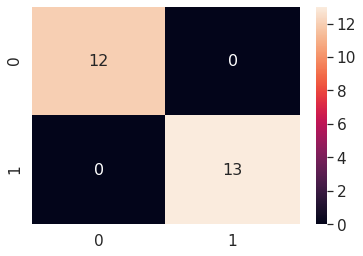

In [9]:
matrix = confusion_matrix(testy, yt_classes)      
df_cm = pd.DataFrame(matrix, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16});# font size

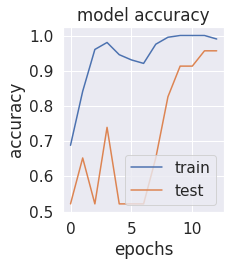

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend();
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.tight_layout();

In [0]:
#saving the model 
# serialize model to JSON
model_json = MobileNet_model.to_json()
with open("MobileNet_model.json", "w") as json_file:
    json_file.write(model_json)
MobileNet_model.save_weights('MobileNet_model_wieghts.h5')